# REPLIED VS BOOKMARKED INTERACTIONS

## Simple comparison between the pairs (user, item) that have had interaction 2 (bookmarked) versus interaction 3 (replied)

This notebook tries to get insights into why users bookmark jobs and why they reply.

Questions to answer:
1. Do they bookmark first and then reply?
2. Why would a user bookmark and not reply?
3. Do they reply and then bookmark?
4. Is there something extra that the job needs to have for the user to reply?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# Import all the interactions of type bookmark
folderData = 'data/'
bookmarked_interactions = pd.read_csv(folderData + 'interactions_bookmarked.csv')
bookmarked_interactions.head()

,user_id,item_id,interaction_type,created_at
0,413650,600,2,1478946404
1,1701797,610,2,1483603622
2,1636343,680,2,1485852887
3,287404,680,2,1486079907
4,794533,890,2,1484200331


In [3]:
# Import all the interactions of type replied
replied_interactions = pd.read_csv(folderData + 'interactions_replied.csv')
replied_interactions.head()

,user_id,item_id,interaction_type,created_at
0,518323,890,3,1483473392
1,472504,1190,3,1485419881
2,1790848,1830,3,1483950415
3,803720,1880,3,1483377509
4,803720,1880,3,1485860254


In [4]:
print replied_interactions.shape
print bookmarked_interactions.shape

(117843, 4)
(281672, 4)


Do we have (user, item) pairs that are common between both groups?

In [5]:
intersection = pd.merge(bookmarked_interactions, replied_interactions, how='inner', on=['user_id', 'item_id'])

In [6]:
intersection.head()

,user_id,item_id,interaction_type_x,created_at_x,interaction_type_y,created_at_y
0,2087348,2210,2,1484645031,3,1484644824
1,2087348,2210,2,1484645031,3,1485808417
2,1169391,3910,2,1486119155,3,1486119160
3,1940658,7900,2,1485345463,3,1485849408
4,796948,8310,2,1484955839,3,1484945861


Did users from the intersection first bookmarked and then replied or vice-versa?

In [7]:
idx = intersection[['created_at_x', 'created_at_y']].max(axis=1)==intersection.created_at_x
idx.value_counts()

False    13618
True      6258
dtype: int64

True means first reply and then bookmark

More than double first bookmark and then reply

Let's analyse all the four groups separately:
1. users who only bookmarked
2. users who only replied
3. users who replied and then bookmarked
4. users who first bookmarked and then replied

In [8]:
idx = bookmarked_interactions['user_id'].isin(intersection['user_id']) & bookmarked_interactions['item_id'].isin(intersection['item_id'])
bookmarked_interactions = bookmarked_interactions[~idx]

In [9]:
idx = replied_interactions['user_id'].isin(intersection['user_id']) & replied_interactions['item_id'].isin(intersection['item_id'])
replied_interactions = replied_interactions[~idx]

In [10]:
intersection1 = intersection[intersection.created_at_y>intersection.created_at_x]
intersection1 = intersection1[['user_id', 'item_id']]
intersection1.head()

,user_id,item_id
1,2087348,2210
2,1169391,3910
3,1940658,7900
5,796948,8310
7,283455,10130


In [11]:
intersection2 = intersection[intersection.created_at_y<intersection.created_at_x]
intersection2 = intersection2[['user_id', 'item_id']]
intersection2.head()

,user_id,item_id
0,2087348,2210
4,796948,8310
6,1368888,9950
10,662189,14700
12,1169503,14720


In [12]:
print intersection1.shape
print intersection2.shape

(13618, 2)
(6209, 2)


In [13]:
# Import all users
users = pd.read_csv(folderData + 'users.csv', sep='\t')
users.columns = ['user_id', 'jobroles', 'career_level', 'discipline_id', 'industry_id', 'country', 'region',
                'experience_n_entries_class', 'experience_years_experience', 'experience_years_in_current',
                'edu_degree', 'edu_fieldofstudies', 'wtcj', 'premium']

In [14]:
# Fill empties and transform the strings into a list
users.jobroles = users.jobroles.fillna('0').apply(lambda str: set(str.split(',')))
users.edu_fieldofstudies = users.edu_fieldofstudies.fillna('0').apply(lambda str: set(str.split(',')))

In [15]:
# Import all items
items = pd.read_csv(folderData + 'items.csv', sep='\t')
items.columns = ['item_id', 'title', 'career_level', 'discipline_id', 'industry_id', 'country', 'is_payed', 'region',
                'latitude', 'longitude', 'employment', 'tags', 'created_at']

In [16]:
# Fill empties and transform the strings into a list
items.title = items.title.fillna('0').apply(lambda str: set(str.split(',')))
items.tags = items.tags.fillna('0').apply(lambda str: set(str.split(',')))
items['created_at_dt'] = pd.to_datetime(items.created_at,unit='s', errors='coerce')

In [17]:
# Merge data sets. Find all the information of users and items that have an interaction of type 2
data_bookmarked = bookmarked_interactions.merge(users, on='user_id', how='inner')
data_bookmarked = data_bookmarked.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))

In [18]:
# Remove interaction type
data_bookmarked.drop(['interaction_type'], axis=1, inplace=True)
data_bookmarked.shape

(261143, 29)

In [19]:
# Merge data sets. Find all the information of users and items that have an interaction of type 3
data_replied = replied_interactions.merge(users, on='user_id', how='inner')
data_replied = data_replied.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))

In [20]:
# Remove interaction type
data_replied.drop(['interaction_type'], axis=1, inplace=True)
data_replied.shape

(96147, 29)

In [21]:
# Merge data sets. Find all the information of users and items that belong to intersection1
data_intersection1 = intersection1.merge(users, on='user_id', how='inner')
data_intersection1 = data_intersection1.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))

In [22]:
# Merge data sets. Find all the information of users and items that belong to intersection2
data_intersection2 = intersection2.merge(users, on='user_id', how='inner')
data_intersection2 = data_intersection2.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))

In [23]:
print data_replied.columns

Index([u'user_id', u'item_id', u'created_at_user', u'jobroles',
       u'career_level_user', u'discipline_id_user', u'industry_id_user',
       u'country_user', u'region_user', u'experience_n_entries_class',
       u'experience_years_experience', u'experience_years_in_current',
       u'edu_degree', u'edu_fieldofstudies', u'wtcj', u'premium', u'title',
       u'career_level_item', u'discipline_id_item', u'industry_id_item',
       u'country_item', u'is_payed', u'region_item', u'latitude', u'longitude',
       u'employment', u'tags', u'created_at_item', u'created_at_dt'],
      dtype='object')


In [24]:
# Select all users and items who have been involved with bookmarked but not replied
idx = users.user_id.isin(data_bookmarked.user_id)
users_bookmarked = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_bookmarked.item_id)
items_bookmarked = items.ix[idx].reset_index(drop=True)

In [25]:
# Select all users and items who have been involved with replied but not bookmarked
idx = users.user_id.isin(data_replied.user_id)
users_replied = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_replied.item_id)
items_replied = items.ix[idx].reset_index(drop=True)

In [26]:
# Select all users and items who which first had interaction bookmark and then reply
idx = users.user_id.isin(data_intersection1.user_id)
users_intersection1 = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_intersection1.item_id)
items_intersection1 = items.ix[idx].reset_index(drop=True)

In [27]:
# Select all users and items who which first had interaction reply and then bookmark
idx = users.user_id.isin(data_intersection2.user_id)
users_intersection2 = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_intersection2.item_id)
items_intersection2 = items.ix[idx].reset_index(drop=True)

In [28]:
print users_bookmarked.shape
print users_replied.shape
print users_intersection1.shape
print users_intersection2.shape

(84797, 14)
(40960, 14)
(6919, 14)
(4280, 14)


# Let's study each one of the columns separately and compare all groups

## Career level

Which career level do users have? Does it match the career level asked at the job?

In [31]:
print data_bookmarked.career_level_user.value_counts().sort_index().to_dict()
print data_replied.career_level_user.value_counts().sort_index().to_dict()
print data_intersection1.career_level_user.value_counts().sort_index().to_dict()
print data_intersection2.career_level_user.value_counts().sort_index().to_dict()

{0: 140958, 1: 3270, 2: 10258, 3: 64722, 4: 29789, 5: 5933, 6: 6213}
{0: 39989, 1: 1161, 2: 3681, 3: 32504, 4: 11558, 5: 3425, 6: 3829}
{0: 2197, 1: 292, 2: 1004, 3: 6220, 4: 2572, 5: 702, 6: 631}
{0: 1044, 1: 127, 2: 419, 3: 2817, 4: 1168, 5: 315, 6: 319}


In [32]:
print data_bookmarked.career_level_item.value_counts().sort_index().to_dict()
print data_replied.career_level_item.value_counts().sort_index().to_dict()
print data_intersection1.career_level_item.value_counts().sort_index().to_dict()
print data_intersection2.career_level_item.value_counts().sort_index().to_dict()

{1: 3026, 2: 29243, 3: 193322, 4: 30852, 5: 3817, 6: 883}
{1: 8018, 2: 4209, 3: 69981, 4: 11505, 5: 1922, 6: 512}
{1: 203, 2: 869, 3: 9482, 4: 2584, 5: 405, 6: 75}
{1: 88, 2: 372, 3: 4255, 4: 1226, 5: 226, 6: 42}


Lets only look at the data for which we know the career level (ignore case 0)

In [33]:
subset1 = data_bookmarked[data_bookmarked.career_level_user!=0]
n = float(len(subset1))
print np.sum(subset1.career_level_item==subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item>subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item<subset1.career_level_user)/n*100.0

54.1174023381
17.8882556059
27.994342056


In [34]:
diff_career_level = subset1.career_level_user-subset1.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-5: 2,
 -4: 12,
 -3: 268,
 -2: 3132,
 -1: 18085,
 0: 65041,
 1: 24373,
 2: 5097,
 3: 3710,
 4: 345,
 5: 120}

Approximately 55% of interaction of type 2 have the same career level

In [35]:
subset2 = data_replied[data_replied.career_level_user!=0]
n = float(len(subset2))
print np.sum(subset2.career_level_item==subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item>subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item<subset2.career_level_user)/n*100.0

58.1858328288
13.9267780192
27.887389152


In [36]:
diff_career_level = subset2.career_level_user-subset2.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-4: 11,
 -3: 80,
 -2: 1138,
 -1: 6592,
 0: 32676,
 1: 9963,
 2: 3147,
 3: 2349,
 4: 133,
 5: 69}

More than 58% have the same career level

Let's look at the ones who bookmarked and then replied and vice-versa

In [37]:
subset3 = data_intersection1[data_intersection1.career_level_user!=0]
n = float(len(subset3))
print np.sum(subset3.career_level_item==subset3.career_level_user)/n*100.0
print np.sum(subset3.career_level_item>subset3.career_level_user)/n*100.0
print np.sum(subset3.career_level_item<subset3.career_level_user)/n*100.0

55.1265213204
17.8355660625
27.0379126171


In [38]:
subset4 = data_intersection2[data_intersection2.career_level_user!=0]
n = float(len(subset4))
print np.sum(subset4.career_level_item==subset4.career_level_user)/n*100.0
print np.sum(subset4.career_level_item>subset4.career_level_user)/n*100.0
print np.sum(subset4.career_level_item<subset4.career_level_user)/n*100.0

56.0309777348
17.5992255566
26.3697967086


They behave in a similar way

## Discipline id

Let's ask the same questions

In [39]:
data_bookmarked.discipline_id_user.value_counts().head()

0     203191
3      10210
4       8007
5       7765
17      6343
Name: discipline_id_user, dtype: int64

In [40]:
data_bookmarked.discipline_id_item.value_counts().head()

1     49109
13    39223
16    37543
5     36978
11    16285
Name: discipline_id_item, dtype: int64

In [41]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset1 = data_bookmarked[data_bookmarked.discipline_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.discipline_id_item==subset1.discipline_id_user)/n*100.0

40.7595941469


Having a discpline match doesn't seem so important when bookmarking a job

In [42]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset2 = data_replied[data_replied.discipline_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.discipline_id_item==subset2.discipline_id_user)/n*100.0

58.0218671152


Whereas it looks more important when replying to post

Are particular disciplines more popular or less popular?

    1. Users

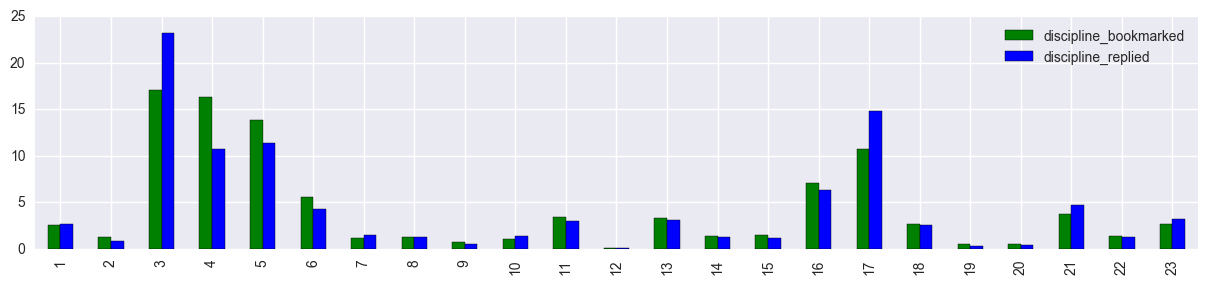

In [43]:
discipline_bookmarked = users_bookmarked[users_bookmarked.discipline_id!=0].discipline_id.value_counts()/len(users_bookmarked[users_bookmarked.discipline_id!=0])*100
discipline_replied = users_replied[users_replied.discipline_id!=0].discipline_id.value_counts()/len(users_replied[users_replied.discipline_id!=0])*100
df = pd.DataFrame({'discipline_bookmarked':discipline_bookmarked, 'discipline_replied':discipline_replied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

    2. items

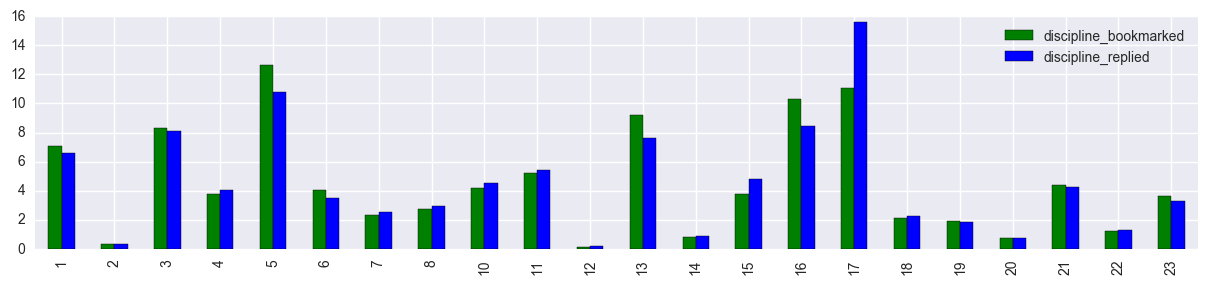

In [44]:
discipline_bookmarked = items_bookmarked[items_bookmarked.discipline_id!=0].discipline_id.value_counts()/len(items_bookmarked[items_bookmarked.discipline_id!=0])*100
discipline_replied = items_replied[items_replied.discipline_id!=0].discipline_id.value_counts()/len(items_replied[items_replied.discipline_id!=0])*100
df = pd.DataFrame({'discipline_bookmarked':discipline_bookmarked, 'discipline_replied':discipline_replied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusions

    1. Many users do not specify discipline, but when it matches with the item discipline it is more likely that the user will be interested than not
    2. There are some disciplines where the percentage of replied is higher, like 3 (for users) and 17 (for items)

## industry_id

In [45]:
data_bookmarked.industry_id_user.value_counts().head(n=5)

0     116429
7      37234
12     32369
16     12981
20      8438
Name: industry_id_user, dtype: int64

In [46]:
data_bookmarked.industry_id_item.value_counts().head(n=5)

16    87423
7     23548
19    21385
3     20637
10    20129
Name: industry_id_item, dtype: int64

In [47]:
data_replied.industry_id_user.value_counts().head(n=5)

0     24613
18    11881
16    10350
7      9609
5      7218
Name: industry_id_user, dtype: int64

In [48]:
data_replied.industry_id_item.value_counts().head(n=5)

16    29776
7     18271
9      7245
3      5986
14     5311
Name: industry_id_item, dtype: int64

In [49]:
subset1 = data_bookmarked[data_bookmarked.industry_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.industry_id_item==subset1.industry_id_user)/n*100.0

16.6217504872


Very few interactions of type bookmarked have a match of industry_id

In [50]:
subset2 = data_replied[data_replied.industry_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.industry_id_item==subset2.industry_id_user)/n*100.0

27.3841809489


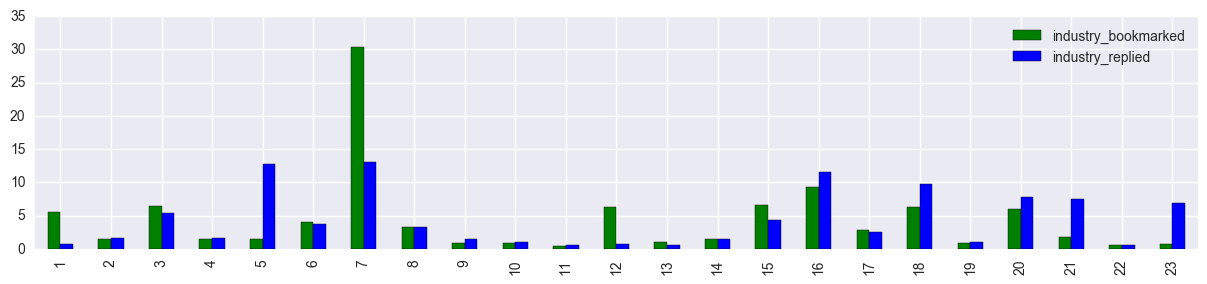

In [51]:
industry_bookmarked = users_bookmarked[users_bookmarked.industry_id!=0].industry_id.value_counts()/len(users_bookmarked[users_bookmarked.industry_id!=0])*100
industry_replied = users_replied[users_replied.industry_id!=0].industry_id.value_counts()/len(users_replied[users_replied.industry_id!=0])*100
df = pd.DataFrame({'industry_bookmarked':industry_bookmarked, 'industry_replied':industry_replied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

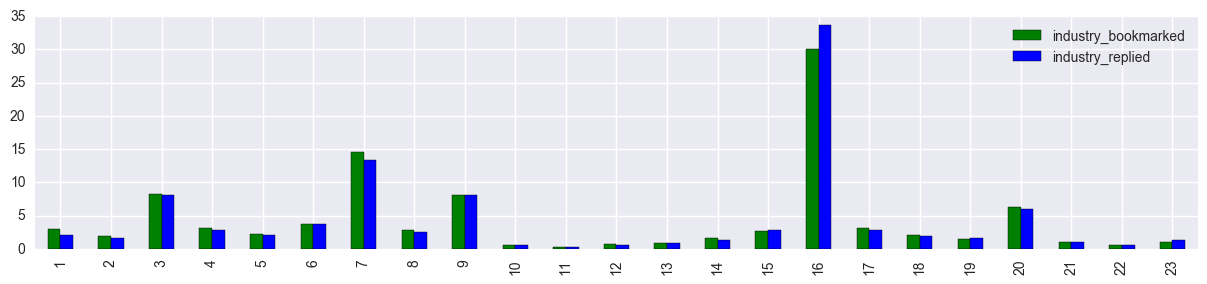

In [52]:
industry_bookmarked = items_bookmarked[items_bookmarked.industry_id!=0].industry_id.value_counts()/len(items_bookmarked[items_bookmarked.industry_id!=0])*100
industry_replied = items_replied[items_replied.industry_id!=0].industry_id.value_counts()/len(items_replied[items_replied.industry_id!=0])*100
df = pd.DataFrame({'industry_bookmarked':industry_bookmarked, 'industry_replied':industry_replied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusions: 

    1. Industry_id match is a lot more relevant for replied interactions than for ony bookmarked

## experience_n_entries_class

In [53]:
data_bookmarked.experience_n_entries_class.value_counts()/float(len(data_bookmarked))*100

3    46.915292
1    28.210597
2    24.874111
Name: experience_n_entries_class, dtype: float64

In [54]:
data_replied.experience_n_entries_class.value_counts()/float(len(data_replied))*100

3    42.003391
1    37.174327
2    20.822283
Name: experience_n_entries_class, dtype: float64

Conclusions: 

    Not much difference

## experience_years_experience & experience_years_in_current

In [55]:
data_bookmarked.experience_years_experience.value_counts()/float(len(data_bookmarked))*100

4    21.862734
5    20.818479
7    16.943973
6    16.344302
0    15.179423
3     5.683859
2     2.537690
1     0.629540
Name: experience_years_experience, dtype: float64

In [56]:
data_replied.experience_years_experience.value_counts()/float(len(data_replied))*100

0    26.253549
4    20.368810
5    16.907444
7    15.933934
6    12.099181
3     4.856106
2     2.913247
1     0.667728
Name: experience_years_experience, dtype: float64

Conclusion:
    1. Less than 8% of the bookmarks and replies are done by users with 1, 2, or 3 years of experience 

In [57]:
data_bookmarked.experience_years_in_current.value_counts()/float(len(data_bookmarked))*100

2    27.919569
0    18.002397
3    14.876141
1    14.704587
4    14.615747
5     5.214002
6     2.829867
7     1.837690
Name: experience_years_in_current, dtype: float64

In [58]:
data_replied.experience_years_in_current.value_counts()/float(len(data_replied))*100

0    28.572914
2    24.688238
1    15.930814
4    12.064859
3    11.598906
5     3.568494
6     2.012543
7     1.563231
Name: experience_years_in_current, dtype: float64

Conclusion:
    1. 28% of bookmarks occur when user has 2 years of experience in current job
    2. At the same time 24% of replies happen when user has 2 years of experience at current job

## edu_degree

In [59]:
data_bookmarked.edu_degree.value_counts()/float(len(data_bookmarked))*100

0    57.612496
2    24.342602
1    12.508089
3     5.536813
Name: edu_degree, dtype: float64

In [60]:
data_bookmarked.edu_degree[data_bookmarked.edu_degree!=0].value_counts()/float(len(data_bookmarked[data_bookmarked.edu_degree!=0]))*100

2    57.428721
1    29.508908
3    13.062371
Name: edu_degree, dtype: float64

In [61]:
data_replied.edu_degree.value_counts()/float(len(data_replied))*100

0    68.945469
2    17.709341
1    10.472506
3     2.872685
Name: edu_degree, dtype: float64

In [62]:
data_replied.edu_degree[data_replied.edu_degree!=0].value_counts()/float(len(data_replied[data_replied.edu_degree!=0]))*100

2    57.026593
1    33.722955
3     9.250452
Name: edu_degree, dtype: float64

Conclusion:
    1. Majority of users have not specifed the edu_degree
    2. Very similar edu_degree statistics between both groups

## field of studies

In [63]:
# Count how many times each field of study appears
field_of_studies_bookmarked = data_bookmarked.edu_fieldofstudies.apply(lambda x: list(x))
field_of_studies_replied = data_replied.edu_fieldofstudies.apply(lambda x: list(x))

In [64]:
import itertools
field_of_studies_bookmarked = list(itertools.chain.from_iterable(field_of_studies_bookmarked.values.flatten()))
field_of_studies_replied = list(itertools.chain.from_iterable(field_of_studies_replied.values.flatten()))

In [65]:
from collections import Counter
{k: v/float(len(field_of_studies_bookmarked))*100 for k, v in dict(Counter(field_of_studies_bookmarked)).items()}

{'0': 42.79221006258523,
 '1': 0.3471906576693123,
 '2': 4.684801230726198,
 '3': 13.365266948708088,
 '4': 1.8684661375476381,
 '5': 7.958113352679977,
 '6': 0.793678542708297,
 '7': 4.757176322506206,
 '8': 22.58417537848327,
 '9': 0.8489213663857906}

In [66]:
{k: v/float(len(field_of_studies_replied))*100 for k, v in dict(Counter(field_of_studies_replied)).items()}

{'0': 51.20523316012038,
 '1': 0.3144927956958032,
 '2': 3.200085154972373,
 '3': 15.76721727097667,
 '4': 1.5734316486196185,
 '5': 8.726449327953087,
 '6': 0.4993177925508753,
 '7': 3.7487541246939746,
 '8': 14.305067688526336,
 '9': 0.6599510358908856}

Conclusions: 
    1. the distribution of field of studied is very similar between the two groups

## WTCJ

In [67]:
data_bookmarked.wtcj.value_counts()/len(data_bookmarked)*100

1    82.153073
0    17.846927
Name: wtcj, dtype: float64

In [68]:
data_replied.wtcj.value_counts()/len(data_replied)*100

1    79.049788
0    20.950212
Name: wtcj, dtype: float64

Conclusion:
    1. There is not a lot of difference between both groups

## premium

In [69]:
data_bookmarked.premium.value_counts()/len(data_bookmarked)*100

0    79.535733
1    20.464267
Name: premium, dtype: float64

In [70]:
data_replied.premium.value_counts()/len(data_replied)*100

0    85.900756
1    14.099244
Name: premium, dtype: float64

Conclusion:
1. Not much difference, but it seems that users who bookmark or reply normally are not premium

## employment

In [71]:
data_bookmarked.employment.value_counts()/float(len(data_bookmarked))*100

1    85.912316
2    13.185496
3     0.498194
4     0.397483
0     0.006510
Name: employment, dtype: float64

In [72]:
data_replied.employment.value_counts()/float(len(data_replied))*100

1    92.542669
2     4.970514
3     1.836771
4     0.629245
0     0.020801
Name: employment, dtype: float64

Conclusions: 
    1. Both groups have majority of jobs full time, however there is 3 times more interest for jobs employment=2 when bookmarking

## title & tag

In [73]:
data_bookmarked.title.head()

0                            {3888938, 46526, 1405401}
1                                     {46526, 1405401}
2                            {3888938, 46526, 1405401}
3                                            {1405401}
4    {2699128, 4238250, 978712, 3218190, 2769260, 6...
Name: title, dtype: object

In [74]:
data_replied.tags.head()

0    {3671787, 3102059, 1786537, 4535088, 4502227, ...
1    {310589, 65768, 1786537, 4535088, 278133, 2739...
2    {1698419, 2994300, 1786537, 88816, 4502227, 27...
3    {1698419, 2994300, 1786537, 88816, 4502227, 27...
4    {4559688, 3121473, 310589, 2729530, 3561652, 3...
Name: tags, dtype: object

In [75]:
def intersect(x):
    return x[0]&x[1]

Find the intersection between titles and tags

In [76]:
data_bookmarked['title_tag_match'] = data_bookmarked[['title', 'tags']].apply(intersect, axis=1)
data_replied['title_tag_match'] = data_replied[['title', 'tags']].apply(intersect, axis=1)

In [77]:
# Count how many titles
data_bookmarked['num_titles'] = data_bookmarked.title.apply(len)
data_bookmarked.num_titles.value_counts()/float(len(data_bookmarked))*100

1     23.430458
3     20.331389
4     16.707321
2     16.524280
7     10.042773
5      5.980631
6      3.268324
9      1.386214
8      1.312308
10     0.461433
11     0.261160
12     0.132112
13     0.071225
14     0.033698
15     0.030635
17     0.009573
16     0.009190
18     0.005361
20     0.000766
19     0.000766
22     0.000383
Name: num_titles, dtype: float64

In [78]:
# Count how many titles
data_replied['num_titles'] = data_replied.title.apply(len)
data_replied.num_titles.value_counts()/float(len(data_replied))*100

2     26.007052
1     20.635069
3     14.956265
5     10.094959
8      9.969110
4      9.255619
6      4.181098
7      2.591865
9      1.013032
10     0.636525
11     0.298501
12     0.151851
13     0.080086
14     0.055124
15     0.037443
18     0.014561
16     0.011441
17     0.007281
20     0.002080
22     0.001040
Name: num_titles, dtype: float64

Conclusions:

1. Not much to extract... at the moment

## is_payed

In [79]:
data_bookmarked.is_payed.value_counts()/float(len(data_bookmarked))*100

0    65.817579
1    34.182421
Name: is_payed, dtype: float64

In [80]:
data_replied.is_payed.value_counts()/float(len(data_replied))*100

0    63.62653
1    36.37347
Name: is_payed, dtype: float64

Conclusions:
    1. Very similar

## Geography

In [85]:
n = float(len(data_replied))
print np.sum(data_replied.country_item==data_replied.country_user)/n*100.0

68.9361082509


In [86]:
n = float(len(data_bookmarked))
print np.sum(data_bookmarked.country_item==data_bookmarked.country_user)/n*100.0

80.9395618493


In [87]:
n = float(len(data_replied))
print np.sum(data_replied.region_item==data_replied.region_user)/n*100.0

32.9734677109


In [88]:
n = float(len(data_bookmarked))
print np.sum(data_bookmarked.region_item==data_bookmarked.region_user)/n*100.0

32.6794131951


Conclusions
    1. From bookmarked interactions, 80% were in the same country and from replied interactions 78% were
    2. The behavious of regions is similar among both groups

# Conclusions

I still need to think but some of the conclusions I have extracted here, but I believe some of them can be converted into features for our classification problem. I will revise this later

# Possible extra features:

- career level match
- career level item > career level user
- discipline match
- industry match
- region match